# Image colorization using CNN


## Libraries and hardware setup



In [ ]:
!pip install kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 7.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pickle
import kornia

from statistics import mean
from skimage.color import rgb2lab

import time

from matplotlib.colors import LogNorm

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import torch.utils.data as data_utils
import torchvision


In [ ]:
torch.cuda.is_available()

False

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import new dataset


In [ ]:
def LAB_to_RGB(l_tensor, ab_tensor):
  tensor = torch.cat([torch.unsqueeze(l_tensor,0), ab_tensor], dim = 0)
  tensor = kornia.color.lab_to_rgb(tensor)
  return tensor

### Train and Validation set

In [ ]:
ab1 = np.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/ab1.npy', encoding='bytes')
ab1_small = torch.tensor(ab1[:, :, :, :], dtype=torch.float16) - 128

del ab1

ab1_small = torch.permute(ab1_small, [0, 3, 1, 2])
print(ab1_small.shape)

torch.Size([10000, 2, 224, 224])


In [ ]:
l = np.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/gray_scale.npy', encoding='bytes')
l_tensor = torch.tensor(l[:10000, :, :], dtype=torch.float32)

del l

l_tensor = l_tensor / 255
print(l_tensor.shape)

torch.Size([10000, 224, 224])


torch.Size([2, 224, 224])
torch.Size([224, 224])


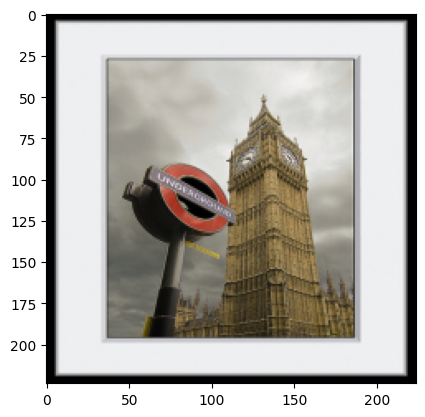

In [ ]:
for x in [8]:
  img_ab = ab1_small[x]
  img_l = l_tensor[x] * 100

  print(img_ab.shape)
  print(img_l.shape)


  img = LAB_to_RGB(img_l, img_ab)
  plt.imshow(torch.permute(img, [1,2,0]))
  plt.show()

In [ ]:
dataset_ab = ab1_small
dataset_l = torch.cat([l_tensor.unsqueeze(0)] * 3, dim=0)
dataset_l = torch.permute(dataset_l, [1,0,2,3])

print(dataset_ab.shape)
print(dataset_l.shape)

torch.Size([10000, 2, 224, 224])
torch.Size([10000, 3, 224, 224])


In [ ]:
del ab1_small
del l_tensor

In [ ]:
train = data_utils.TensorDataset(dataset_l[: 9000], dataset_ab[: 9000])
test = data_utils.TensorDataset(dataset_l[9000:], dataset_ab[9000:])

In [ ]:
del dataset_l
del dataset_ab

### Test set

In [ ]:
ab = np.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/ab2.npy', encoding='bytes')
ab_test = torch.tensor(ab[:100, :, :, :], dtype=torch.float16) - 128

del ab

ab_test = torch.permute(ab_test, [0, 3, 1, 2])
print(ab_test.shape)

l = np.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/gray_scale.npy', encoding='bytes')
l_test = torch.tensor(l[10000:10100, :, :], dtype=torch.float32)

del l

l_test = l_test / 255
print(l_test.shape)

torch.Size([100, 2, 224, 224])
torch.Size([100, 224, 224])


torch.Size([2, 224, 224])
torch.Size([224, 224])


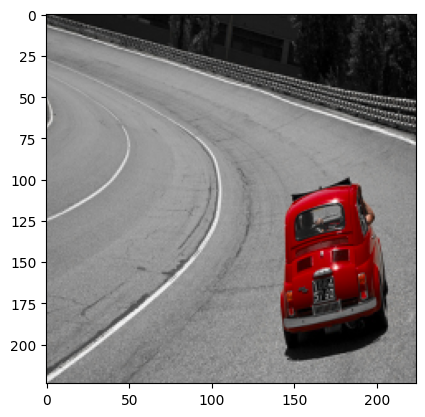

In [ ]:
for x in range(1):
  img_ab_test = ab_test[x]
  img_l_test = l_test[x] * 100

  print(img_ab_test.shape)
  print(img_l_test.shape)


  img = LAB_to_RGB(img_l_test, img_ab_test)
  plt.imshow(torch.permute(img, [1,2,0]))
  plt.show()

In [ ]:
dataset_ab_test = ab_test
dataset_l_test = torch.cat([l_test.unsqueeze(0)] * 3, dim=0)
dataset_l_test = torch.permute(dataset_l_test, [1,0,2,3])

print(dataset_ab_test.shape)
print(dataset_l_test.shape)

del ab_test
del l_test

final_test = data_utils.TensorDataset(dataset_l_test, dataset_ab_test)

del dataset_l_test
del dataset_ab_test

torch.Size([100, 2, 224, 224])
torch.Size([100, 3, 224, 224])


## Training (L2 loss)


In [ ]:
batch_size = 100
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
class network_model_L2(nn.Module):
  def __init__(self):
    super(network_model_L2, self).__init__()

    resnet = models.resnet18(weights = "IMAGENET1K_V1")
    self.resnet_base = nn.Sequential(*list(resnet.children())[0:6]) #first 6 layers of resnet, which end with 128 channels

    for param in self.resnet_base.parameters():
      param.requires_grad = False

    # define our layers on top of resnet
    self.cnn_next = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )


  def forward(self, input):
    y = self.resnet_base(input) #first go through resnet
    z = self.cnn_next(y)        #then go through our layers
    return z

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

network = network_model_L2()            # CNN
loss = nn.MSELoss()                     # We begin with a simple MSE loss function
optim = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=0.0)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.2MB/s]


In [ ]:
losses_train = []
losses_val = []

epochs = 100
patience = 10                                                                   # how many epochs of non decreasing validation we accept
min_val = 0                                                                     # minimum validation loss (initialized to a meaningless value - we will update it at the first epoch)

PATH = "L2_model_trained_horizontalflip.pt"


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])


with torch.autograd.set_detect_anomaly(False):
  for epoch in range(epochs):
    print("Epoch ", epoch)
    network.train()                                                             #Set it up for training
    i = 0
    ls = []
    for features, labels in train_loader:
      transformed_batch = torch.stack([transform(img) for img in features])

      features = transformed_batch
      features = features.to(device)
      labels = labels.to(device)
      network = network.to(device)



      now = time.time()
      predictions = network(features)
      then = time.time()


      L = loss(predictions, labels.type(torch.float32))
      ls.append(L.item())

      optim.zero_grad()
      L.backward()
      optim.step()

      if i%50 == 0:
        print("Loss at iteration ",  i , " is ", L.item())
      i += 1

    losses_train.append(mean(ls))


#########################################################################################

    # Validation loss
    network.eval()
    with torch.no_grad():
      val_batches = []
      for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        network = network.to(device)

        prediction_val = network(features)

        val_loss = loss(prediction_val, labels.type(torch.float32))
        val_batches.append(val_loss.item())
      print("At epoch ", epoch, " validation loss ", mean(val_batches))
      print("The minimum was:", min_val)
      losses_val.append(mean(val_batches))


    # Early stopping
    if epoch == 1:
      min_val = mean(val_batches)

    if mean(val_batches) < min_val:
      min_val = mean(val_batches)
      torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': min_val,
            }, PATH)

    # Early stopping: break if no new minimum was reached in the last *patience* epochs

    if epoch >= patience:
        condition = 0
        for index in range(patience):
          if losses_val[-(index + 1)] > min_val:
            condition += 1
        if condition == patience:
          print("Early stopping!")
          break

Epoch  0
Loss at iteration  0  is  287.4208068847656
Loss at iteration  50  is  275.5728454589844
At epoch  0  validation loss  259.01279602050784
The minimum was: 0
Epoch  1
Loss at iteration  0  is  224.0914764404297
Loss at iteration  50  is  259.1773986816406
At epoch  1  validation loss  257.0612258911133
The minimum was: 0
Epoch  2
Loss at iteration  0  is  252.45994567871094
Loss at iteration  50  is  263.5132141113281
At epoch  2  validation loss  255.34314727783203
The minimum was: 257.0612258911133
Epoch  3
Loss at iteration  0  is  234.49407958984375
Loss at iteration  50  is  273.35601806640625
At epoch  3  validation loss  253.74353942871093
The minimum was: 255.34314727783203
Epoch  4
Loss at iteration  0  is  262.9632873535156
Loss at iteration  50  is  186.7567901611328
At epoch  4  validation loss  250.88000946044923
The minimum was: 253.74353942871093
Epoch  5
Loss at iteration  0  is  260.9144287109375
Loss at iteration  50  is  279.58355712890625
At epoch  5  valida

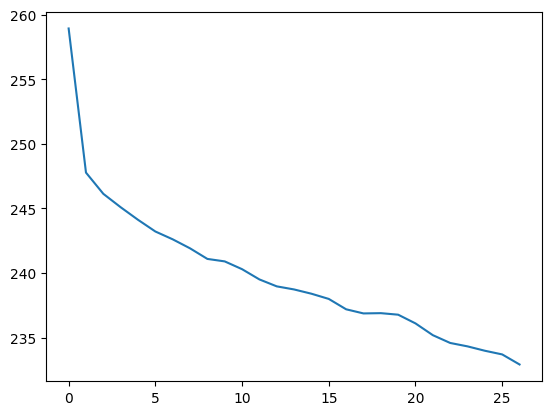

In [ ]:
plt.plot(losses_train)

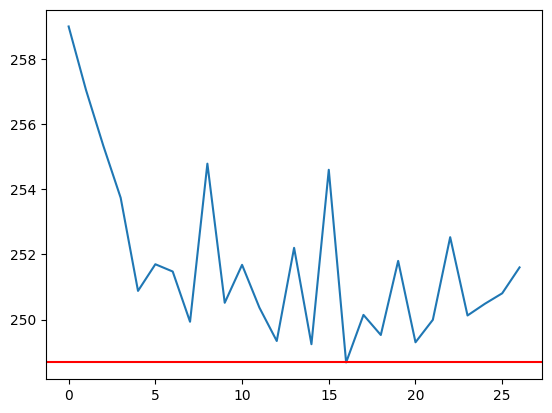

In [ ]:
plt.plot(losses_val)
plt.axhline(y=min_val, color='r', linestyle='-')

In [ ]:
min_val

248.67819366455078

## Display output on test images

In [ ]:
network = network_model_L2()
data = torch.load('/content/gdrive/MyDrive/Vision/Progetto/PROGETTO_FINALE/L2_model_trained_horizontalflip_larger.pt', map_location=torch.device('cpu'))

network.load_state_dict(data['model_state_dict'])

network.eval()

network_model_L2(
  (resnet_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
for r in range(len(final_test)):

  L = final_test[r][0]
  ab =  final_test[r][1]

  # original
  input_RGB = LAB_to_RGB(L[0]*100, ab)
  input_cpu = input_RGB.cpu()
  input_img = np.transpose(input_cpu, (1, 2, 0)).numpy()

  # output
  output = network(torch.unsqueeze(L, 0))
  output_RGB = LAB_to_RGB(L[0, :, :]*100, output[0].cpu())
  output_cpu = output_RGB.cpu()
  output_img = np.transpose(output_cpu.detach().numpy(), (1, 2, 0))

  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  axes[0].imshow(L[0], cmap='gray')
  axes[0].axis('off')  # Turn off axis
  axes[0].set_title('Gray scale')

  axes[1].imshow(output_img)
  axes[1].axis('off')  # Turn off axis
  axes[1].set_title('Reconstructed')

  axes[2].imshow(input_img)
  axes[2].axis('off')  # Turn off axis
  axes[2].set_title('Original')

  plt.show()

  print()

Output hidden; open in https://colab.research.google.com to view.